In [368]:
import elasticsearch
import git
import os
from git import Repo
import sys

def create_components(git_url,esurl,localdir):
    # if no url supplied for Elastic, assume the localhost
    if esurl =='':
        try:
            es = elasticsearch.Elasticsearch(['http://localhost:9200/'])
        except:
            print('Elasticsearch not running at localhost:9200')
            sys.exit(1)
    else:
        try:
            es = elasticsearch.Elasticsearch([esurl])
        except:
            print('Elasticsearch not running at the given URL. For default localhost, do not provide the argument')
            sys.exit(1)
        
    # Get the default commit index name
    es_index_raw = str.split(git_url,'/')[-1].split('.')[0]+'_'+'index'
    # Get the default blame index name
    es_blame_index_raw = str.split(git_url,'/')[-1].split('.')[0]+'_'+'blame'+'_'+'index'
    es_index = es_index_raw.lower()
    es_blame_index = es_blame_index_raw.lower()
    # Create elasticsearch instance
    
    # If local Repo path is not supplied, create default path in '/tmp'
    if localdir == '':
        if sys.platform == 'linux':
            local_dir ='/tmp/'+str.split(git_url,'/')[-1].split('.')[0]
        else:
            local_dir ='C:\\Downloads'+str.split(git_url,'/')[-1].split('.')[0]
    else:
        local_dir = localdir
    # Check if the local Repo already exists
    if os.path.isdir(local_dir):
        # Load the local Repo
        try:
            repo = git.Repo(local_dir)   
        # Get the latest commit object in the local Repo
            local_commit = repo.commit()     
        except:
            print('No valid Repo found at the location. If unsure, remove the directory and try without local dir argument')
            sys.exit(1)
                       # latest local commit 
        
        # Get the latest commit object in the remote Repo
        remote = git.remote.Remote(repo, 'origin')      # remote repo
        info = remote.fetch()[0]                        # fetch changes
        remote_commit = info.commit  
        
        # If latest commit in local and remote differ refresh the local Repo
        if (local_commit.hexsha == remote_commit.hexsha ):
            print('No changes in the Repo...')
        else:    
            repo = git.Repo(local_dir) 
            o = repo.remotes.origin
            o.pull()
            # Analyse and store additional commit data
            store_commit_data(local_dir,es,es_index,es_blame_index,local_commit.hexsha,remote_commit.hexsha )
    else:
        # If no local Repo exists, clone the Repo
        try:
            if sys.platform == 'linux':
                git.Git('/tmp').clone(git_url)
            else:
                git.Git('C:\\Downloads').clone(git_url)
        except:
            print('Not able to clone the Repo. If there is a non Git directory with the  same name, delete it and then try')
            sys.exit(1)
        # Delete the elastic indices, if exist
        es.indices.delete(index=es_index, ignore=[400, 404])
        es.indices.delete(index=es_blame_index, ignore=[400, 404])
        # Create new elastic indices
        es.indices.create(es_index)
        es.indices.create(es_blame_index)
        # Call the function to store the necessary commit data
        store_commit_data(local_dir,es,es_index,es_blame_index,'None','None')

    return es,es_index,es_blame_index

In [369]:
import elasticsearch
from elasticsearch_dsl import Search,Q
import pandas as pd
import git
import re
from pydriller import RepositoryMining
from elasticsearch import helpers
from git import Repo
import os
def store_commit_data(local_dir,es,es_index,es_blame_index,local_commit,remote_commit):
    
    repo = Repo(local_dir)
    # Creating empty lists for carrying commit data
    doclist = []
    blamelist =[]
    # If the Repo has just been cloned, the program will traverse the whole Repo
    if(local_commit == 'None'):
        # using PyDriller's API.
        for commit in RepositoryMining(local_dir).traverse_commits():
               for mod in commit.modifications:
                    #Building Commit tuples
                    commit_data = {'hash':commit.hash,'Author':commit.author.name,'Email':commit.author.email,
                                       'message':commit.msg,'authored_date':commit.author_date,
                                       'Committer':commit.committer.name,'committed_date':commit.committer_date,
                                       'no._of_branches':len(commit.branches),'merge_commit?':commit.merge,
                                       'no._of_mod_files':len(commit.modifications),'dmm_unit_size':commit.dmm_unit_size,
                                       'dmm_unit_complexity':commit.dmm_unit_complexity,'dmm_unit_interfacing':commit.dmm_unit_interfacing,
                                       'file_name':mod.filename, 'file_path':mod.new_path, 'complexity': mod.complexity, 'functions': len(mod.methods),
                                       'lines_added':mod.added,'lines_removed': mod.removed,'loc':mod.nloc,'size': 0 if mod.source_code is None else len(mod.source_code.splitlines()),'tokens':mod.token_count
                                       
                                        }
                    # loading each commit tuple into the list
                    doclist.append(commit_data)
                    # Each modification object contains diff_parsed tag with "added" and "deleted" properties. 
                    alines = mod.diff_parsed['added']
                    # "added" property is a tuple list with line number and actual line text. List of text lines is extracted
                    addedlines = [x[1] if len(alines)>0 else 'None' for x in alines ]
                    
                    # Each modification object contains diff_parsed tag with "added" and "deleted" properties. 
                    blines = mod.diff_parsed['deleted']
                    # "deleted" property is a tuple list with line number and actual line text. List of text lines is extracted
                    deletedlines = [x[1] if len(blines)>0 else 'None' for x in blines]
                    count = 0
                    
                    # Absolute path of the file in the cloned repo. This is required to validate that the file has not been deleted in the subsequent commits
                    newfilepath = local_dir+'/'+str(mod.new_path)
                    # For bug fix commits, retrieving the blame data. Using Regex on Commit messages to identify bug fix commits
                    if len(re.findall(r"\bbug\b|\bBug\b|\bFix\b|\bfix\b",commit.msg))>0 and os.path.isfile(newfilepath):# & len(addedlines)>0:
                        # Running Git Blame on each added line.
                        for eachline in addedlines:
                            repo_blame = repo.blame(commit.hash,mod.new_path,eachline)
                            # Git Blame of a line can produce multiple records with each record representing a past modification
                            for blame_record in repo_blame:
                                # Git Blame produces duplicate records (Don't know why). Attempt to ignore duplicated by comparting the current record with the previous record
                                # Also Git Blame produces record of the same commit hash, which can be ignored
                                prev_record = ''
                                if str(commit.hash) !=str(blame_record[0]) and (str(blame_record[0]) != prev_record):
                                    # Building Blame tuple for each Blame record
                                    blame_doc = {'orig_hash':commit.hash,'blame_hash':str(blame_record[0]),
                                                    'file':mod.new_path}    
                                    # Loading blame data into the list
                                    blamelist.append(blame_doc)
                                    prev_record = blame_record[0]



    else:
        #if Repo has been refreshed, only delta commits are processed
        for commit in RepositoryMining(local_dir,from_commit = local_commit, to_commit = remote_commit ).traverse_commits():
            for mod in commit.modifications:
                    #Building Commit tuples
                    commit_data = {'hash':commit.hash,'Author':commit.author.name,'Email':commit.author.email,
                                       'message':commit.msg,'authored_date':commit.author_date,
                                       'Committer':commit.committer.name,'committed_date':commit.committer_date,
                                       'no._of_branches':len(commit.branches),'merge_commit?':commit.merge,
                                       'no._of_mod_files':len(commit.modifications),'dmm_unit_size':commit.dmm_unit_size,
                                       'dmm_unit_complexity':commit.dmm_unit_complexity,'dmm_unit_interfacing':commit.dmm_unit_interfacing,
                                       'file_name':mod.filename, 'file_path':mod.new_path, 'complexity': mod.complexity, 'functions': len(mod.methods),
                                       'lines_added':mod.added,'lines_removed': mod.removed,'loc':mod.nloc,'size': 0 if mod.source_code is None else len(mod.source_code.splitlines()),'tokens':mod.token_count
                                       
                                        }
                    # loading each commit tuple into the list
                    doclist.append(commit_data)
                    # Each modification object contains diff_parsed tag with "added" and "deleted" properties. 
                    alines = mod.diff_parsed['added']
                    # "added" property is a tuple list with line number and actual line text. List of text lines is extracted
                    addedlines = [x[1] if len(alines)>0 else 'None' for x in alines ]
                    
                    # Each modification object contains diff_parsed tag with "added" and "deleted" properties. 
                    blines = mod.diff_parsed['deleted']
                    # "deleted" property is a tuple list with line number and actual line text. List of text lines is extracted
                    deletedlines = [x[1] if len(blines)>0 else 'None' for x in blines]
                    count = 0
                    
                    # Absolute path of the file in the cloned repo. This is required to validate that the file has not been deleted in the subsequent commits
                    newfilepath = local_dir+'/'+str(mod.new_path)
                    # For bug fix commits, retrieving the blame data. Using Regex on Commit messages to identify bug fix commits
                    if len(re.findall(r"\bbug\b|\bBug\b|\bFix\b|\bfix\b",commit.msg))>0 and os.path.isfile(newfilepath):# & len(addedlines)>0:
                        # Running Git Blame on each added line.
                        for eachline in addedlines:
                            repo_blame = repo.blame(commit.hash,mod.new_path,eachline)
                            # Git Blame of a line can produce multiple records with each record representing a past modification
                            for blame_record in repo_blame:
                                # Git Blame produces duplicate records (Don't know why). Attempt to ignore duplicated by comparting the current record with the previous record
                                # Also Git Blame produces record of the same commit hash, which can be ignored
                                prev_record = ''
                                if str(commit.hash) !=str(blame_record[0]) and (str(blame_record[0]) != prev_record):
                                    # Building Blame tuple for each Blame record
                                    blame_doc = {'orig_hash':commit.hash,'blame_hash':str(blame_record[0]),
                                                    'file':mod.new_path}    
                                    # Loading blame data into the list
                                    blamelist.append(blame_doc)
                                    prev_record = blame_record[0]



    # using elasticsearch.py's helper tools to bulk load into elasticsearch's commit index           
    helpers.bulk(es,doclist,index=es_index,doc_type ='commit_data',request_timeout = 2000)
    # Since Git Blame produces duplicate data, getting only unique records
    blamelist_fil = [i for n, i in enumerate(blamelist) if i not in blamelist[n + 1:]]
    # using elasticsearch.py's helper tools to bulk load into elasticsearch's blame index
    helpers.bulk(es,blamelist_fil,index=es_blame_index,doc_type ='blame',request_timeout = 2000)
    # Very important to explicitly refresh the Elastic indices as they are not automatically done.
    es.indices.refresh([es_blame_index,es_index])


In [367]:
# Calling the base method to process and load the commit data. See "create_components" method for detail
p = create_components('https://github.com/R-Knowsys/elasticray.git','','')
p1 = create_components('https://github.com/chaoss/grimoirelab.git','','')



No changes in the Repo...
No changes in the Repo...


In [370]:
import elasticsearch
from elasticsearch_dsl import Search,Q
import pandas as pd

def get_user_data(es_instance,commit_index,blame_index):
        # Assigning Elastic instance, Commit Elastic Index and Blame Elastic Index to variables
        es = es_instance
        es_ma_index = commit_index
        es_bl_index = blame_index
        # Using Elasticsearch DSL function to get the data of Commit index
        blame_es_data = Search(using=es, index=es_bl_index)
        # Loading data into a dictionary
        blame_dict = [hit.to_dict() for hit in blame_es_data.scan()]
        # Using Elasticsearch DSL function to get the data of Blame index
        commit_es_data = Search(using=es, index=es_ma_index)
        # Loading data into a dictionary
        commit_dict = [hit.to_dict() for hit in commit_es_data.scan()]
        # Creating pandas dataframe for commit data
        commit_frame = pd.DataFrame(commit_dict)
        # Creating pandas dataframe for blame data
        blame_frame = pd.DataFrame(blame_dict)
        # Getting the blame row count. If the frmae is empty, it means all the records are clean
        blame_count = blame_frame.shape[0]
        
        if blame_count>0:
            # Adding a column to Blame frame indicating that the row represents a Buggy commit
            blame_frame['type'] = 'Buggy'
            # Combining Commit frmae with Blame frame. An additional column called 'type' gets added to the Commit frame.
            comb_frame = pd.merge(commit_frame,blame_frame,how='left',left_on = ['hash','file_path'],right_on = ['blame_hash','file'])
        else:
            # If the Blame frame is empty, no need to merge.
            comb_frame=commit_frame
        # When merging happnes and 'type' column gets added to the main Commit frame, The rows that are not part of Blame frame are filled with 'Nan'.
        # Here, all the NaNs fro 'type' column are replaced with 'Clean' label.
        # Effectively, Each commit file (one Commit can contain more than one file) is categorised as either Buggy or Clean.
        comb_frame['type'] = comb_frame['type'].fillna('Clean')
        
        # Cleaning and retaining the required columns
        comb_frame_refined = comb_frame[['hash', 'Author','Committer', 'Email', 'message',                               'committed_date', 'no._of_branches', 'merge_commit?',
                                        'no._of_mod_files', 'dmm_unit_size', 'dmm_unit_complexity','dmm_unit_interfacing',
                                        'file_path', 'complexity','functions', 'lines_added', 'lines_removed', 'size', 'tokens',
                                        'type']]
        # Commit hash raw value is very long. Cutting the value into first ten chars 
        # Assumption is that the first ten chars rednder necessary uniqueness. May need to revisit later
        comb_frame_refined['hash'] = comb_frame_refined['hash'].str.slice(0,10)

        # Changing the type from string to Data. Used Pacific time zone. Heard the pacific coast is beautiful
        commit_frame['committed_date'] = commit_frame['committed_date'].astype('str').apply(lambda x: pd.to_datetime(x).tz_convert('US/Pacific'))
        
        # Sorting the frame by committes date
        comb_frame_refined = comb_frame_refined.sort_values('committed_date', ascending=False)
        
        #------ Attempting to score developers with a simple/simplistic calculation -----/
        
        # Replacing all NaN fields with zero
        comb_frame_refined = comb_frame_refined.fillna(0)
        # Adding commit count (actually commit file count) for each other column
        comb_frame_refined['commit_count'] = comb_frame_refined.groupby('Author').hash.transform('nunique')
        # Adding up three dmm values creating a new column
        comb_frame_refined['riskfreescore'] = comb_frame_refined['dmm_unit_size']+comb_frame_refined['dmm_unit_complexity']+comb_frame_refined['dmm_unit_interfacing']
        # Adding up "Lines Added" and "Lines Removed" and creating a new column
        comb_frame_refined['lineschanged'] = comb_frame_refined['lines_added']+comb_frame_refined['lines_removed']
        # Simple calculation to come up with a score for each row
        comb_frame_refined['score'] = comb_frame_refined.apply(lambda x:((x.riskfreescore)*10+(x.lineschanged)+(x.complexity)*10)/10,axis =1)
        # Filtering out the necessary columns and creating a new frame
        dev_score = comb_frame_refined[['Author','commit_count','score','type']]
        # Score is scaled based on the type of commit file
        dev_score['scaled_score'] = dev_score.apply(lambda x: x.score if x.type == 'Clean' else x.score/2,axis=1)
        # Retaining the necessary columns
        dev_score_refined = dev_score[['Author','commit_count','scaled_score']]
        # Calculating the Average score for the Author. A simple arithmetic mean.
        dev_score_refined['average_score'] = dev_score_refined.groupby('Author').scaled_score.transform('mean').round()
        dev_score_final = dev_score_refined[['Author','commit_count','average_score']].drop_duplicates().sort_values('average_score', ascending=False).reset_index().drop(columns = 'index') 
        return dev_score_final

In [371]:
import elasticsearch
from elasticsearch_dsl import Search,Q
import pandas as pd

def get_latest_commits(es_instance,commit_index,blame_index):
        # Assigning Elastic instance, Commit Elastic Index and Blame Elastic Index to variables
        es = es_instance
        es_ma_index = commit_index
        es_bl_index = blame_index
        # Using Elasticsearch DSL function to get the data of Commit index
        blame_es_data = Search(using=es, index=es_bl_index)
        # Loading data into a dictionary
        blame_dict = [hit.to_dict() for hit in blame_es_data.scan()]
        # Using Elasticsearch DSL function to get the data of Blame index
        commit_es_data = Search(using=es, index=es_ma_index)
        # Loading data into a dictionary
        commit_dict = [hit.to_dict() for hit in commit_es_data.scan()]
        # Creating pandas dataframe for commit data
        commit_frame = pd.DataFrame(commit_dict)
        # Creating pandas dataframe for blame data
        blame_frame = pd.DataFrame(blame_dict)
        # Getting the blame row count. If the frmae is empty, it means all the records are clean
        blame_count = blame_frame.shape[0]
        
        if blame_count>0:
            # Adding a column to Blame frame indicating that the row represents a Buggy commit
            blame_frame['type'] = 'Buggy'
            # Combining Commit frmae with Blame frame. An additional column called 'type' gets added to the Commit frame.
            comb_frame = pd.merge(commit_frame,blame_frame,how='left',left_on = ['hash','file_path'],right_on = ['blame_hash','file'])
        else:
            # If the Blame frame is empty, no need to merge.
            comb_frame=commit_frame
        # When merging happnes and 'type' column gets added to the main Commit frame, The rows that are not part of Blame frame are filled with 'Nan'.
        # Here, all the NaNs fro 'type' column are replaced with 'Clean' label.
        # Effectively, Each commit file (one Commit can contain more than one file) is categorised as either Buggy or Clean.
        comb_frame['type'] = comb_frame['type'].fillna('Clean')
        
        # Cleaning and retaining the required columns
        comb_frame_refined = comb_frame[['hash', 'Author','Committer', 'Email', 'message',                               'committed_date', 'no._of_branches', 'merge_commit?',
                                        'no._of_mod_files', 'dmm_unit_size', 'dmm_unit_complexity','dmm_unit_interfacing',
                                        'file_path', 'complexity','functions', 'lines_added', 'lines_removed', 'size', 'tokens',
                                        'type']]
        # Commit hash raw value is very long. Cutting the value into first ten chars 
        # Assumption is that the first ten chars rednder necessary uniqueness. May need to revisit later
        comb_frame_refined['hash'] = comb_frame_refined['hash'].str.slice(0,10)

        # Changing the type from string to Data. Used Pacific time zone. Heard the pacific coast is beautiful
        commit_frame['committed_date'] = commit_frame['committed_date'].astype('str').apply(lambda x: pd.to_datetime(x).tz_convert('US/Pacific'))
        # Sorting the frame by committes date
        comb_frame_refined = comb_frame_refined.sort_values('committed_date', ascending=False)
        
        return comb_frame_refined

In [ ]:
# Following cells contain the code catering for K-Means clustering

In [10]:
# Processing data for few Git Repos. Look into the above method definitions for detail
p = create_components('https://github.com/R-Knowsys/elasticray.git','','')
p1 = create_components('https://github.com/chaoss/grimoirelab.git','','')

# Getting the commit data as pandas frames
elastic_commits = get_latest_commits(p[0],p[1],p[2])
grimoire_commits = get_latest_commits(p1[0],p1[1],p1[2])

# Combining commit data from two Git Repos. Add as many Repos as you like
total_commits = elastic_commits.append(grimoire_commits)
print(total_commits.shape)

/home/vamsi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(859, 19)
(1882, 19)
(2741, 19)


In [372]:
# Preprocessing the data. ML requires the data to be converted to numericals
ml_commits = total_commits[['Author', 'no._of_mod_files', 'dmm_unit_size',
       'dmm_unit_complexity', 'dmm_unit_interfacing', 'complexity', 'functions', 'lines_added', 'lines_removed', 
       'tokens', 'type']]
# Assign 15 to Clean row and 5 to buggy row
ml_commits['type'] = ml_commits['type'].apply(lambda x:15 if x=='Clean' else 5)
# Resetting the frame's index. It is required to retain the integrity of the frame
ml_commits = ml_commits.reset_index().drop(columns = 'index')
# Author column needs to be dropped before converting the all the fields into numeric types
ml_commits_na = ml_commits.drop(columns = ['Author'])
# Converting the fields to numeric types, filling the NaNs with zeros
ml_commits_numeric =ml_commits_na.apply(pd.to_numeric,errors ='coerce').fillna(0)
# Adding teh Author column back
ml_commits_numeric['Author']=ml_commits['Author']
ml_commits_numeric_na = ml_commits_numeric.drop(columns=['Author'])

print(ml_commits_numeric.shape)
print(ml_commits_numeric_na.shape)

(2741, 11)
(2741, 10)


/home/vamsi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [373]:
# Attempt to remove outliers. May not be required
from scipy import stats
#df = ml_commits_numeric
#df1 = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
ml_commits_nout = ml_commits_numeric[(np.abs(stats.zscore(ml_commits_numeric.select_dtypes(exclude='object'))) < 3).all(axis=1)]
ml_commits_mode = ml_commits_nout.select_dtypes(exclude='object').mode()
ml_commits_out = ml_commits_numeric[~(np.abs(stats.zscore(ml_commits_numeric.select_dtypes(exclude='object'))) < 3).all(axis=1)]
#print(ml_commits_nout.shape)
#print(ml_commits_numeric.shape)
index = 0
'''
while index<ml_commits_mode.size-1:
    
    ml_commits_out.iloc[:,index] = ml_commits_mode.iloc[0,index]
    index +=1
'''
#df3.iloc[:,0] = df2.iloc[0,0]
ml_commits_all = ml_commits_nout.append(ml_commits_out).reset_index()
ml_commits_fil = ml_commits_all[['Author','complexity','lines_added','type']]

ml_commits_all_na = ml_commits_all.drop(columns = ['Author'])
ml_commits_fil_na = ml_commits_fil.drop(columns = ['Author'])
print(ml_commits_all_na.shape)
print(ml_commits_all.shape)
ml_commits_all.columns

(2741, 11)
(2741, 12)


Index(['index', 'no._of_mod_files', 'dmm_unit_size', 'dmm_unit_complexity',
       'dmm_unit_interfacing', 'complexity', 'functions', 'lines_added',
       'lines_removed', 'tokens', 'type', 'Author'],
      dtype='object')

In [374]:
# Dimentionality Reduction before training with Kmeans.
# Dimentionality Reduction is the technique used to identify the most influential features for machine learning
# The input data in this case contains just ten features. Hence, this may not be required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

# Assigning the input frame to a simpler variable
df = ml_commits_numeric_na
# Creating the instance of Standard Scaler
scaler = StandardScaler()
# Transforming the input data using Standard Scaler
data_scaled = scaler.fit_transform(df)
# Creating the instance of PCA. PCA is a popular tool for the purpose of Dimentionality Reduction
pca = PCA()
# Processing the scaled data using PCA
pca.fit(data_scaled)
# Printing the variance ratio for each feature. FYI, each column of the frame represents a feature
pca.explained_variance_ratio_


array([3.14954771e-01, 2.92064959e-01, 1.21053617e-01, 1.07968315e-01,
       8.92074953e-02, 6.31123554e-02, 6.15262260e-03, 3.98397424e-03,
       1.34506545e-03, 1.56825360e-04])

Text(0, 0.5, 'Cumulatve Explained Variance')

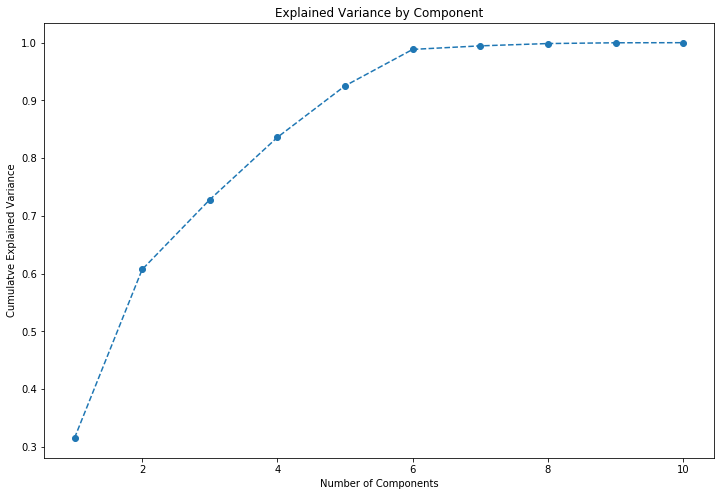

In [376]:
#Plotting the variance ratios for each feature
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(range(1,11),pca.explained_variance_ratio_.cumsum(),marker = 'o',linestyle = '--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulatve Explained Variance')

In [377]:
# From the above plot, it is clear that first three features have major impact on variance. And the last five have no imapct at all.
# Hence, we can try Kmeans with first three features
pca = PCA(n_components = 3)
pca.fit(data_scaled)
scores_pca = pca.transform(data_scaled)
print(scores_pca.shape)

(2741, 3)


Text(0, 0.5, 'Inertia')

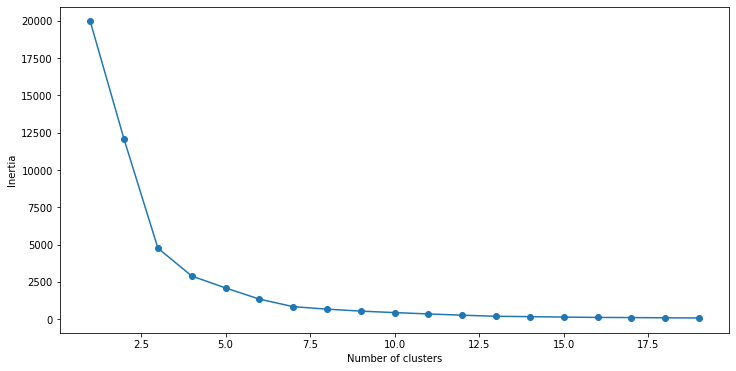

In [378]:
# Inertia calculation provides insights into required number of Clusters

SSE = []

for cluster in range(1,20):
    kmeans_pca = KMeans(n_clusters = cluster, init='k-means++',random_state = 42)
    kmeans_pca.fit(scores_pca)
    SSE.append(kmeans_pca.inertia_)

    # converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
df = ml_commits_numeric_na
scaler = StandardScaler()
normalizer = Normalizer()
data_scaled = scaler.fit_transform(df)

data_normalized = normalizer.fit_transform(df)
'''
pd.DataFrame(data_scaled).describe()
kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(data_scaled)
kmeans.inertia_
'''
kmeans = KMeans(n_clusters = 5, init='random',max_iter = 10)
s = kmeans.fit(data_scaled)
p = kmeans.fit(data_normalized)
q = kmeans.fit(scores_pca)
s_centroids = s.cluster_centers_
p_centroids = p.cluster_centers_
q_centroids = q.cluster_centers_
#pred = kmeans.predict(data_scaled)
print(s.labels_.astype(float))
print(p.labels_.astype(float))
print(q.labels_.astype(float))
print(s_centroids)
print(p_centroids)
print(q_centroids)
print(data_scaled.shape)
print(data_normalized.shape)
print(scores_pca.shape)

[2. 2. 2. ... 2. 2. 3.]
[2. 2. 2. ... 2. 2. 3.]
[2. 2. 2. ... 2. 2. 3.]
[[-1.52990363  1.23206559  1.59534071]
 [54.54847193 65.79973187 -2.84184581]
 [ 1.64427192 -1.36012077  0.21847143]
 [-0.94483014  0.6263195  -0.70155312]
 [ 7.19662092  6.5906537   0.95026356]]
[[-1.52990363  1.23206559  1.59534071]
 [54.54847193 65.79973187 -2.84184581]
 [ 1.64427192 -1.36012077  0.21847143]
 [-0.94483014  0.6263195  -0.70155312]
 [ 7.19662092  6.5906537   0.95026356]]
[[-1.52990363  1.23206559  1.59534071]
 [54.54847193 65.79973187 -2.84184581]
 [ 1.64427192 -1.36012077  0.21847143]
 [-0.94483014  0.6263195  -0.70155312]
 [ 7.19662092  6.5906537   0.95026356]]
(2741, 10)
(2741, 10)
(2741, 3)


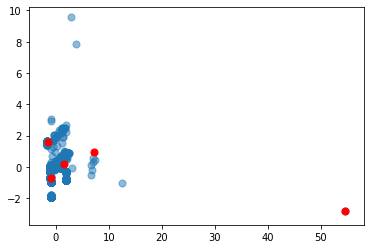

In [393]:
# Training the input frame with PCA processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
df = ml_commits_numeric_na
scaler = StandardScaler()
normalizer = Normalizer()
data_scaled = scaler.fit_transform(df)


pca = PCA(n_components = 3)
pca.fit(data_scaled)
scores_pca = pca.transform(data_scaled)
kmeans = KMeans(n_clusters = 5, init='random',max_iter = 10)
q = kmeans.fit(scores_pca)

plt.scatter(scores_pca[:,0], scores_pca[:,2], s=50, alpha=0.5)
plt.scatter(q_centroids[:, 0], q_centroids[:, 2], c='red', s=50)
plt.show()

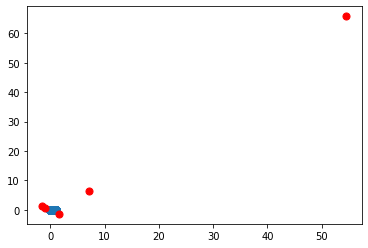

In [397]:
# Training the normalized input frame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
df = ml_commits_numeric_na

normalizer = Normalizer()
data_normalized = normalizer.fit_transform(df)

kmeans = KMeans(n_clusters = 5, init='random',max_iter = 10)
p = kmeans.fit(data_normalized)


plt.scatter(data_normalized[:,0], data_normalized[:,1], s=50, alpha=0.5)
plt.scatter(p_centroids[:, 0], p_centroids[:, 1], c='red', s=50)
plt.show()

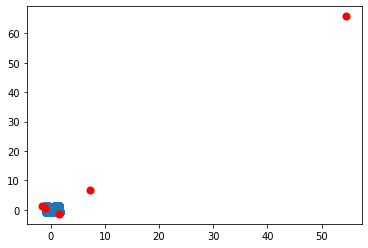

In [398]:
# Training the scaled input frame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
df = ml_commits_numeric_na
scaler = StandardScaler()

data_scaled = scaler.fit_transform(df)

kmeans = KMeans(n_clusters = 5, init='random',max_iter = 10)
s = kmeans.fit(data_scaled)

plt.scatter(data_scaled[:,0], data_scaled[:,1], s=50, alpha=0.5)
plt.scatter(s_centroids[:, 0], s_centroids[:,1], c='red', s=50)
plt.show()


pd.DataFrame(data_scaled).describe()
kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(data_scaled)
kmeans.inertia_

For n_clusters = 2 The average silhouette_score is : 0.5101867043471549
For n_clusters = 3 The average silhouette_score is : 0.5777482569619683
For n_clusters = 4 The average silhouette_score is : 0.6495175643402606
For n_clusters = 5 The average silhouette_score is : 0.6677110620096952
For n_clusters = 6 The average silhouette_score is : 0.6466612635106612
For n_clusters = 8 The average silhouette_score is : 0.6027484458568982


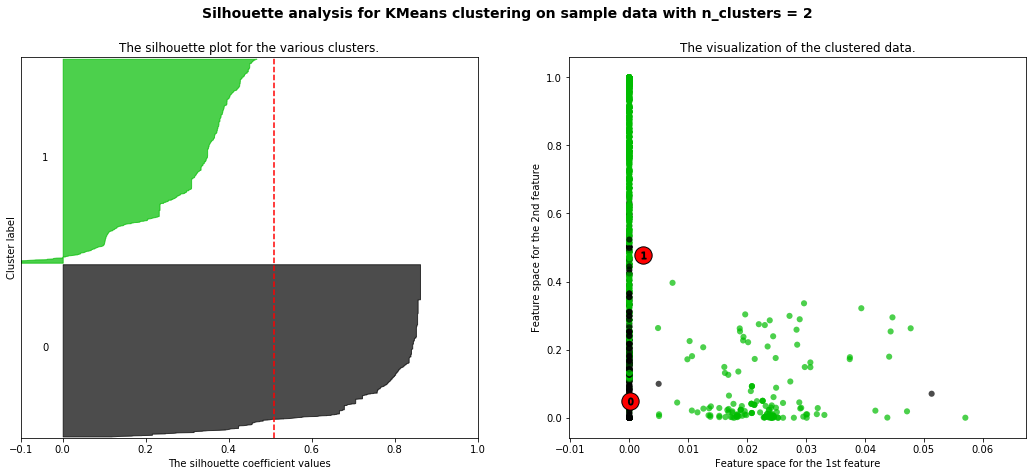

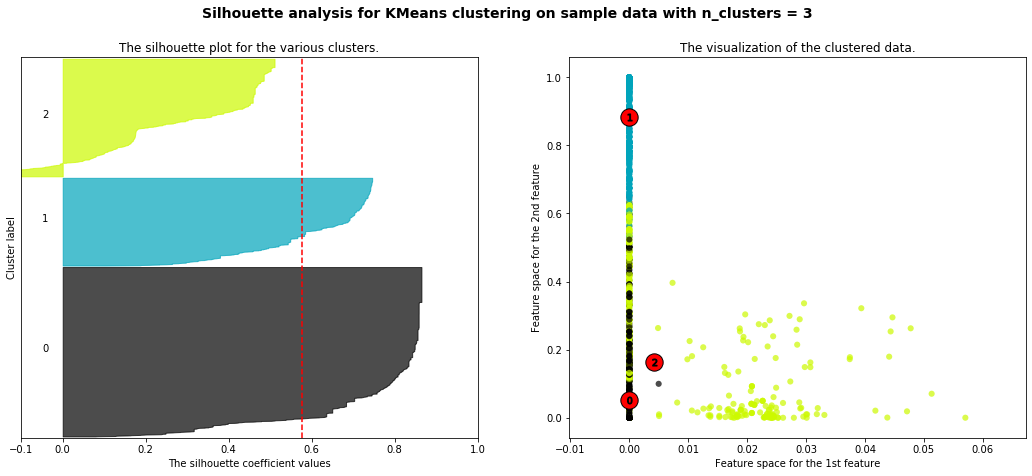

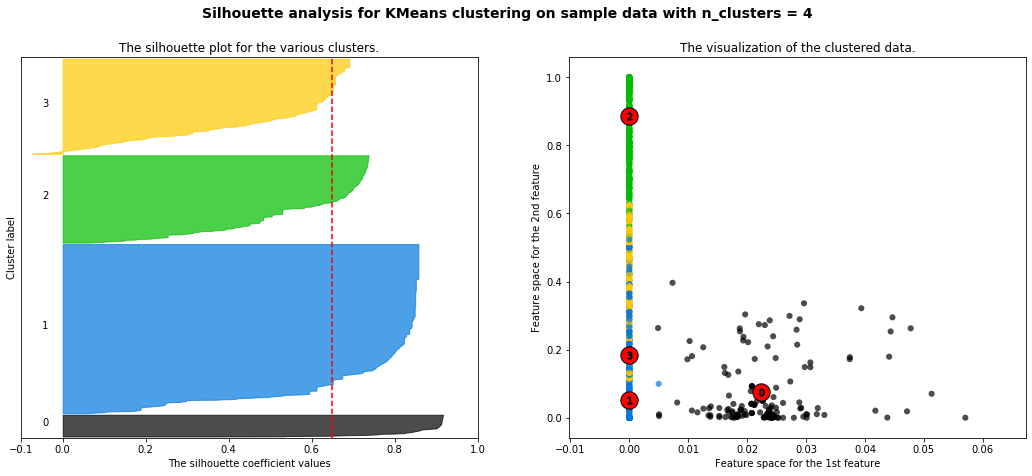

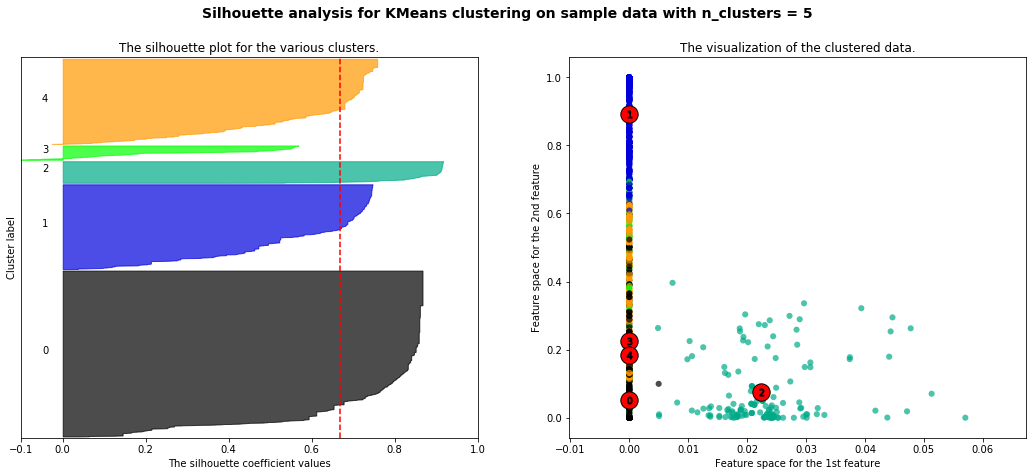

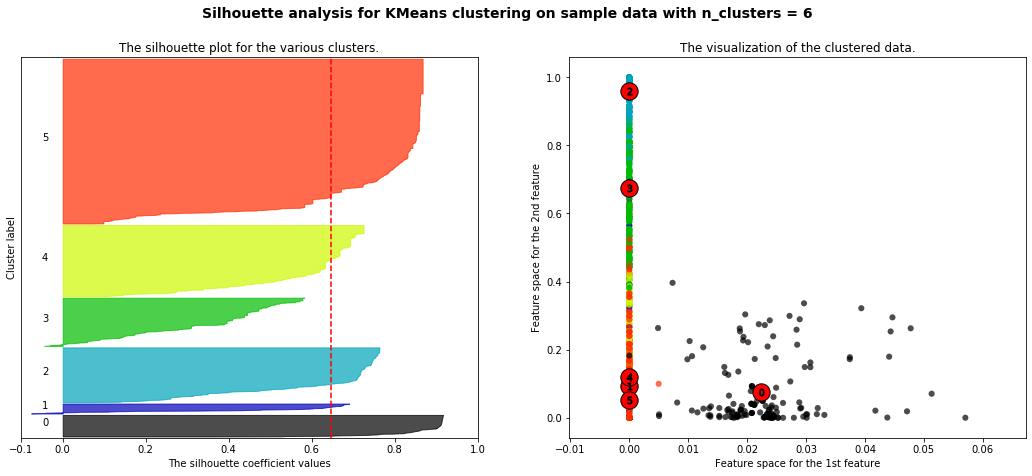

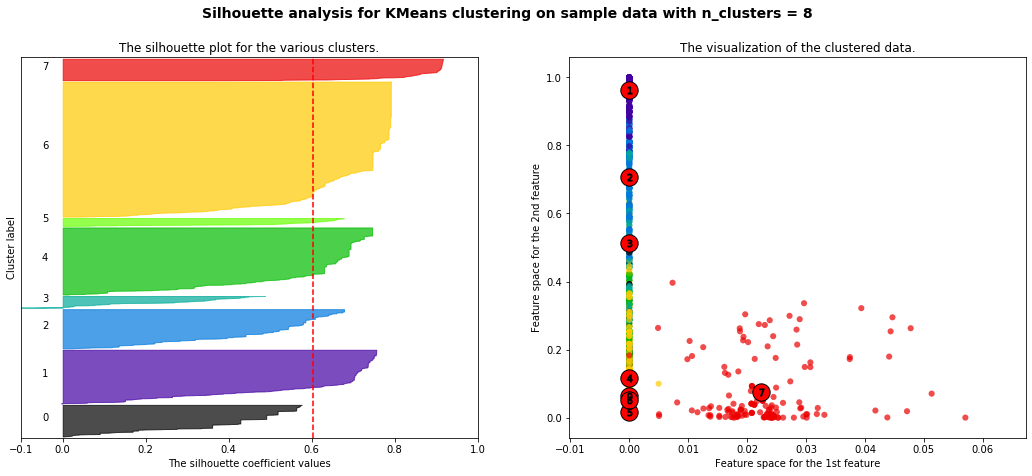

In [399]:
# Function to try out various input models
# Includes measurement of quality of Clustering through silhouette_scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# X can be assigned to any input frame.
X = data_normalized
# If you want to try out Scaled frame, replace the above line with the following
# X = data_scaled
# For PCA frame, replace with the following line
# X = scores_pca
range_n_clusters = [2, 3, 4, 5, 6,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,max_iter = 50,init = 'random')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values =  sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # In the below line, two features, X[:,4] and X[:,6] are selected for plotting
    # Those features can be replaced with any other two features.
    # Keep in mind that, the frame contains ten features, from X[:,0] to X[:,9]
    # In the case of PCA, there are only three features selected after the dimentionality reduction.
    # Hence, if the X is assigned to scores_pca, you can select from X[:,0] to X[:2]
    ax2.scatter(X[:, 4], X[:, 6], marker='.', s=150, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    # The centers should have same positions as features. 
    ax2.scatter(centers[:,4], centers[:,6], marker='o',
                c="red", alpha=1, s=300, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[4], c[6], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


pd.DataFrame(data_scaled).describe()
kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(data_scaled)
kmeans.inertia_

For n_clusters = 2 The average silhouette_score is : 0.8474723588928902
For n_clusters = 3 The average silhouette_score is : 0.8315790733253924
For n_clusters = 4 The average silhouette_score is : 0.7650742736517486
For n_clusters = 5 The average silhouette_score is : 0.8283904781887378
For n_clusters = 6 The average silhouette_score is : 0.8290830781222567
For n_clusters = 8 The average silhouette_score is : 0.8636839244793624


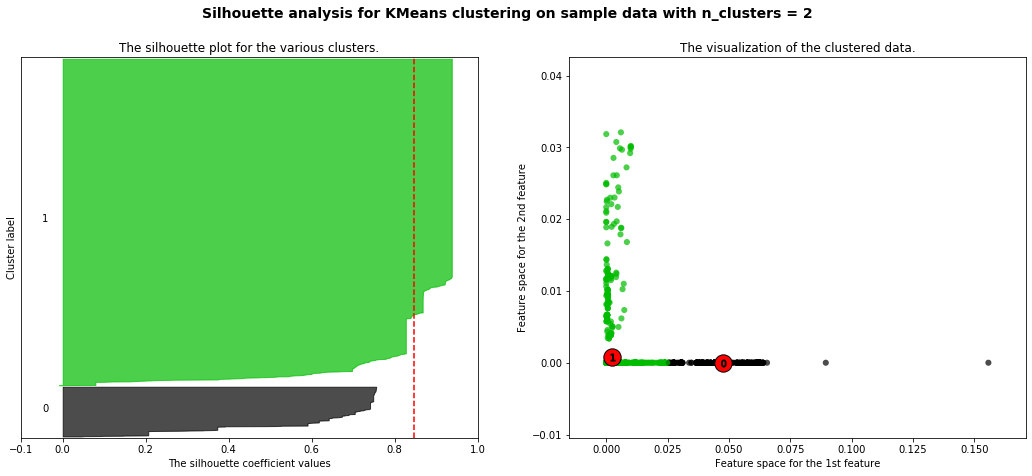

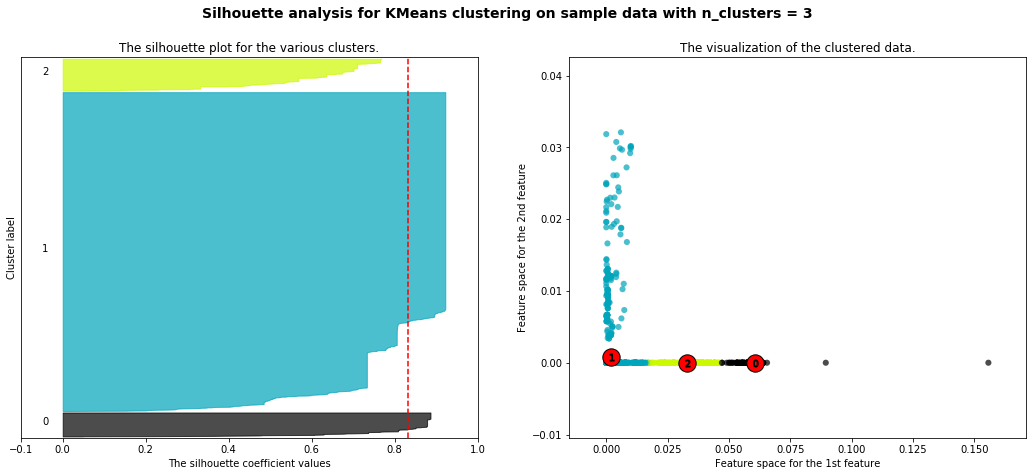

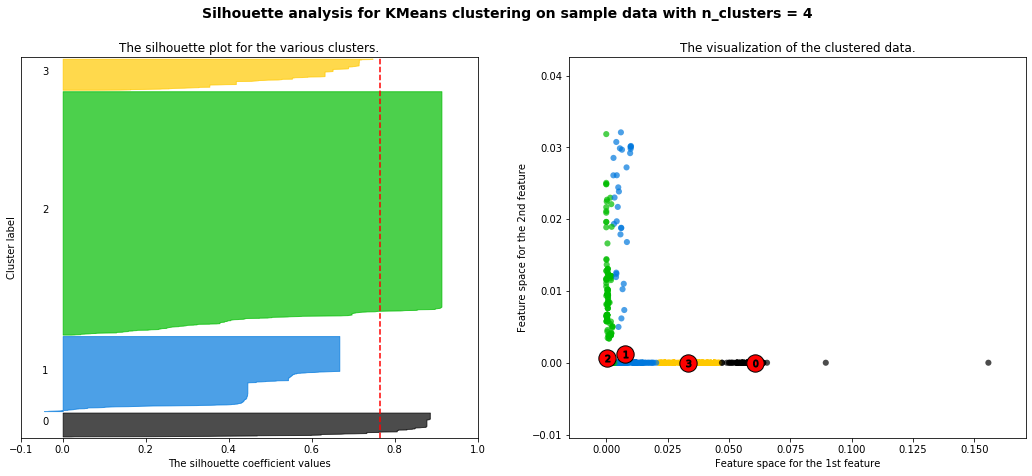

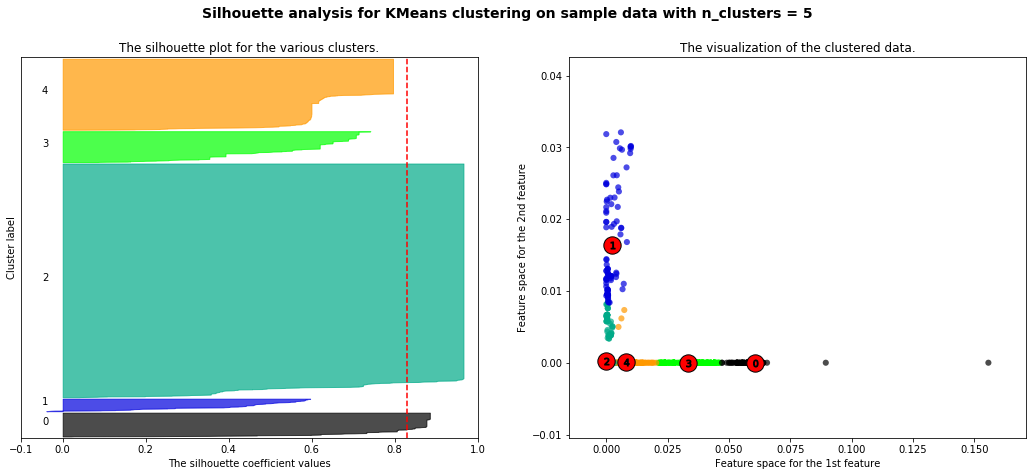

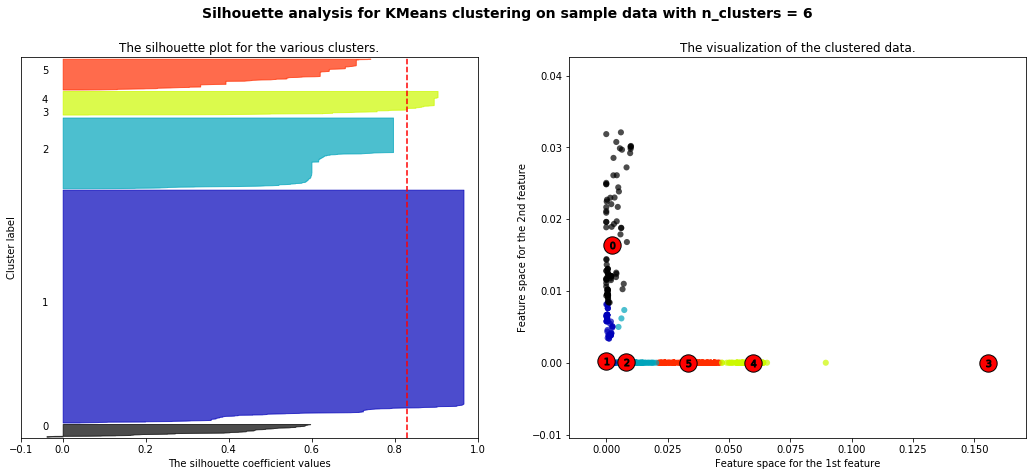

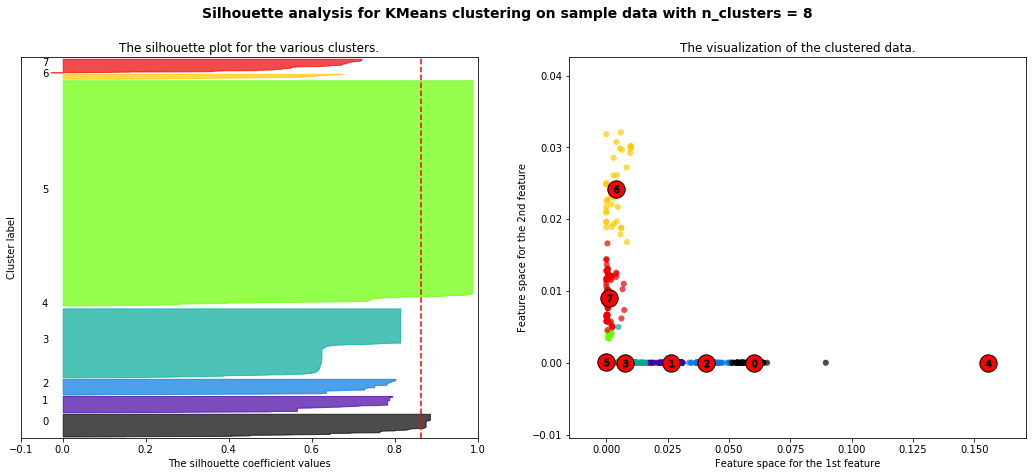

In [402]:
# Function to try out various input models
# This is same as the above except that the input is limited to just two features
# The puprose here is to understand how cluster behaves if we have same number of training features as plotted
# Includes measurement of quality of Clustering through silhouette_scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# X can be assigned to any input frame.
X = data_normalized[:,[3,5]]
# If you want to try out Scaled frame, replace the above line with the following
# X = data_scaled[:,[3,5]]
# For PCA frame, replace with the following line
# X = scores_pca[:,[0,1]]
range_n_clusters = [2, 3, 4, 5, 6,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,max_iter = 50,init = 'random')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values =  sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # Here, we can only plot X[:, 0], X[:, 1] as the training was done on just two features
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=150, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    # The centers should have same positions as features. 
    ax2.scatter(centers[:,0], centers[:,1], marker='o',
                c="red", alpha=1, s=300, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [404]:
# Predicting the Cluster for individual Authors
kmeans = KMeans(n_clusters = 5, init='random',max_iter = 10)
# Using data_scaled. This can be replaced with data_normalized or scores_pca
s = kmeans.fit(data_scaled)
# Converting the input data series into pandas Dataframe
cluster_frame = pd.DataFrame(data_scaled)
# Adding Author column to the frame. Since the frame indices match, we can use the base input columns
cluster_frame['Author'] = ml_commits_numeric['Author']
# Calculating mean of each column values grouped by the Author
clust_auth_frame = cluster_frame.groupby(['Author'],as_index=True).mean()#.reset_index()#.drop(columns = 'index')

# predicting the cluster for each author. Keep in mind that the above step creates Authors as index of the input frame
auth_pred_scores = kmeans.predict(clust_auth_frame)

# Adding the predicted cluster as a column
clust_auth_frame['cluster'] = auth_pred_scores

clust_auth_frame[['cluster']]

,cluster
Author,
Abdon Pijpelink,0
Ajay Kottapally,0
Alberto Martín,4
Alvaro del Castillo,4
Animesh Kumar,4
Benjamin Copeland,4
Brent Beer,4
Chase Miller,4
David Moreno,4


In [342]:
import scipy.stats as ss
data_scaled = scaler.fit_transform(ml_commits_all_na)
num_cols = len(scores_pca[0,:])
for i in range(num_cols):
    col = scores_pca[:,i]
    col_stats = ss.describe(col)
    print(col_stats)

DescribeResult(nobs=2741, minmax=(-1.8430749985419332, 21.828433871275973), mean=0.0, variance=3.355321653448367, skewness=2.2361446854824854, kurtosis=11.800393234086636)
DescribeResult(nobs=2741, minmax=(-2.005322530541476, 24.11583709518149), mean=9.33219207857118e-17, variance=2.7673188834188025, skewness=2.975857654174269, kurtosis=24.756757481217285)
DescribeResult(nobs=2741, minmax=(-2.4856738135951755, 7.781701305207428), mean=-8.295281847618827e-17, variance=1.4881670738487809, skewness=0.7435434732618057, kurtosis=0.2562656414263582)
